# Results check 

This notebook confirms that the results output by `src`, e.g. the synthetic data, the Kalman tracking etc. all look reasonable and nothing odd is going on 

# Setup 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    sys.path.remove("../src") # Remove src if already exists 
except:
    pass
sys.path.append("../src") # Means that I dont have to make src/ a proper python package

# Synthetic data 

We generate synthetic data to test our scheme. 

Lets make sure this looks reasonable 

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData

P   = SystemParameters()    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data    

first state phase value =  0.0
first state frequency value =  0.0


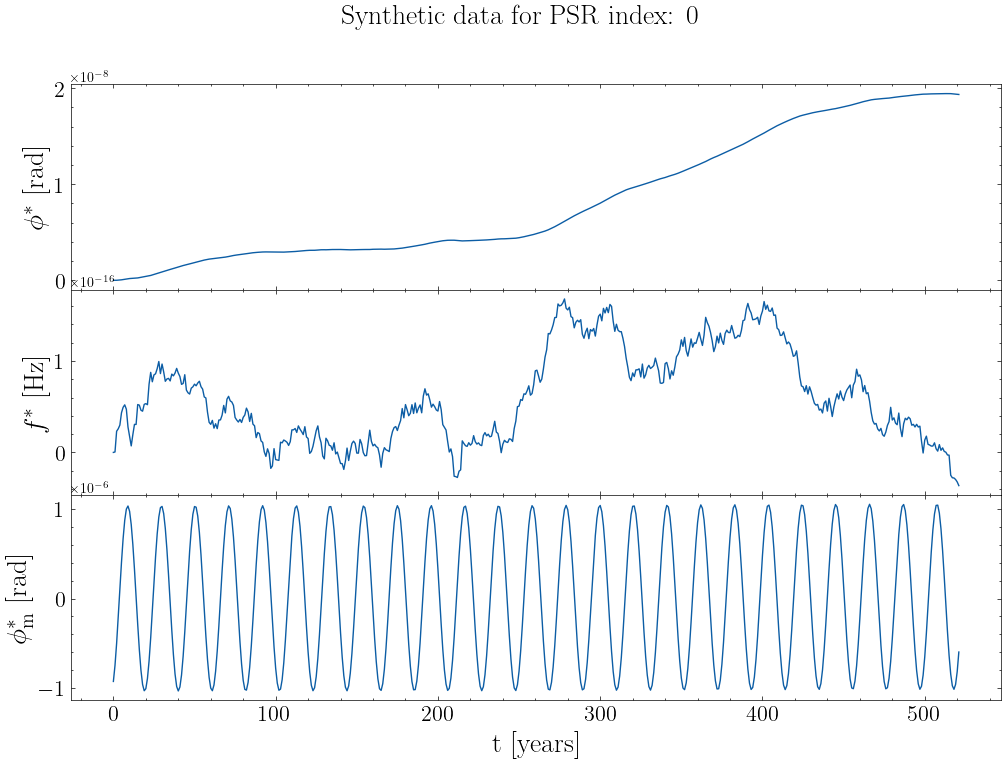

In [4]:
from plotting import plot_synthetic_data
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0)

Looks reasonable. The measurement (bottom panel) looks a bit clean. We can crank the noise (need to consider what a reasonable physical value is)

first state phase value =  0.0
first state frequency value =  0.0


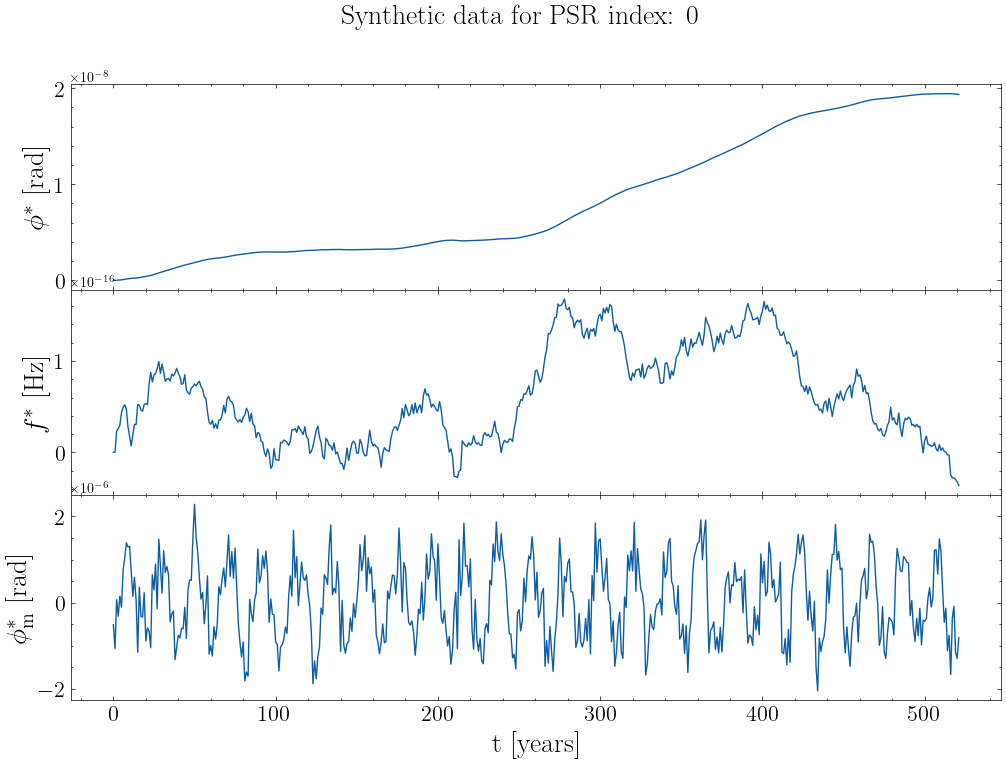

In [5]:
P   = SystemParameters(σm=5e-7)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data    
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0)

Notice how the states in the two above plots are identical, despite being a stochastic process.

This is because we have seeded the random-ness. If we try a different seed, the state evolution should be different:

first state phase value =  0.0
first state frequency value =  0.0


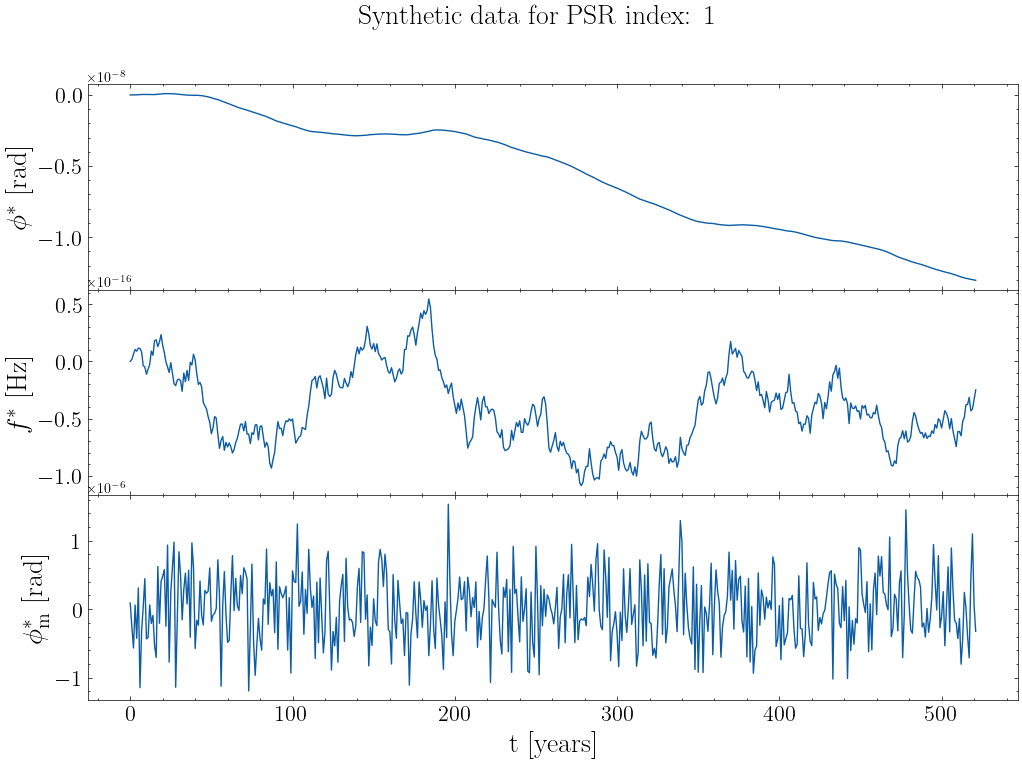

In [6]:
P   = SystemParameters(σm=5e-7,seed=1230)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data    
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=1)

Looks good!

# Kalman filter 

We have confirmed that our data looks ok. How does our KF do when we run it on the data? 

In [48]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import PhaseModel
from kalman_filter import KalmanFilter
from priors import bilby_priors_dict


P   = SystemParameters(seed=1230,Npsr=2,σm=5e-8)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = PhaseModel(P)


#Initialise the Kalman filter
KF = KalmanFilter(model,data.phi_measured,PTA)

#Run the KF with the correct parameters.
#We get the correct parameters via Bilby dictionary, looking towards when we will run this with nested sampling
import numpy as np 

constrained_prior = bilby_priors_dict(PTA,P,set_state_parameters_as_known=True,set_measurement_parameters_as_known=True)
optimal_parameters = constrained_prior.sample(1)
ll,xresults,yresults = KF.likelihood(optimal_parameters)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1230
INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Pulsar terms measurement model
INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


16052.141384545903


first state phase value =  0.0
first state frequency value =  0.0
The likelihood is -204580.1737317357


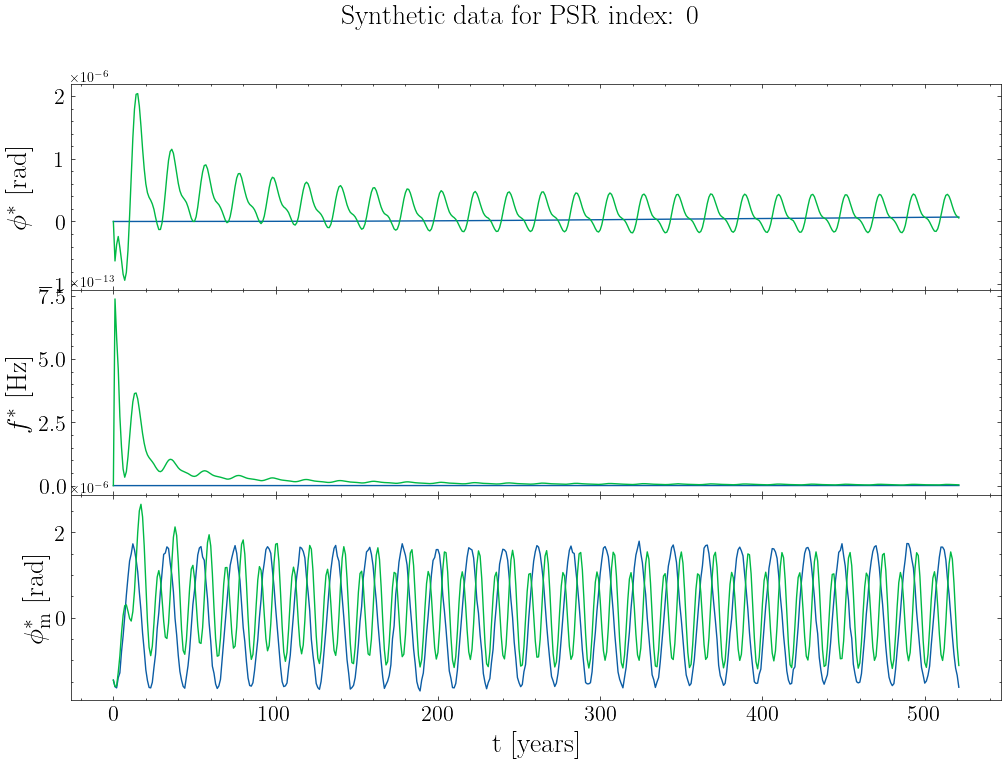

In [47]:
#...and plot the results 
results_phi = xresults[:,0::2]
results_f = xresults[:,1::2] 
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0,state_phi_pred=results_phi,state_f_pred=results_f,phi_measured_pred=yresults)
print(f"The likelihood is {ll}")

That looks reasonable. The $\phi$ state and the measurement state are well tracked. The $f$ state is less well tracked, but this is a pure stochastic process. I don't think we should be able to track it...?

What happens if we crank the measurement noise again?



INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1230
INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Pulsar terms measurement model
INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


400.30807999656327 1.911370365935989e-15 86.38022212123923
1651.6974688374403 1.264751169125603e-26 86.38022212123923
nan 9.065753350517398e-11 86.38022212123923
nan 1.1710901960746805 86.38022212123923
-1281.7997879596264 33.3805864528934 86.38022212123923
-1308.574807261983 37.70769858082245 86.38022212123923
-1321.7153406734847 36.57309757563682 86.38022212123923
-1329.693166616134 55.12799465563042 86.38022212123923
-1335.0893356188633 30.743240531270832 86.38022212123923
-1338.9946110452581 57.48184278911199 86.38022212123923
-1341.9566197595568 33.491201297112404 86.38022212123923
-1344.2824189975204 33.70532093168791 86.38022212123923
-1346.1581647885941 57.82927866021765 86.38022212123923
-1347.7035303351133 51.09955782856207 86.38022212123923
-1348.9990583224974 63.0213178277193 86.38022212123923
-1350.1009954557403 53.24317940417302 86.38022212123923
-1351.0498361589596 32.52074104906181 86.38022212123923
-1351.875489429709 49.02861150537521 86.38022212123923
-1352.6005329159

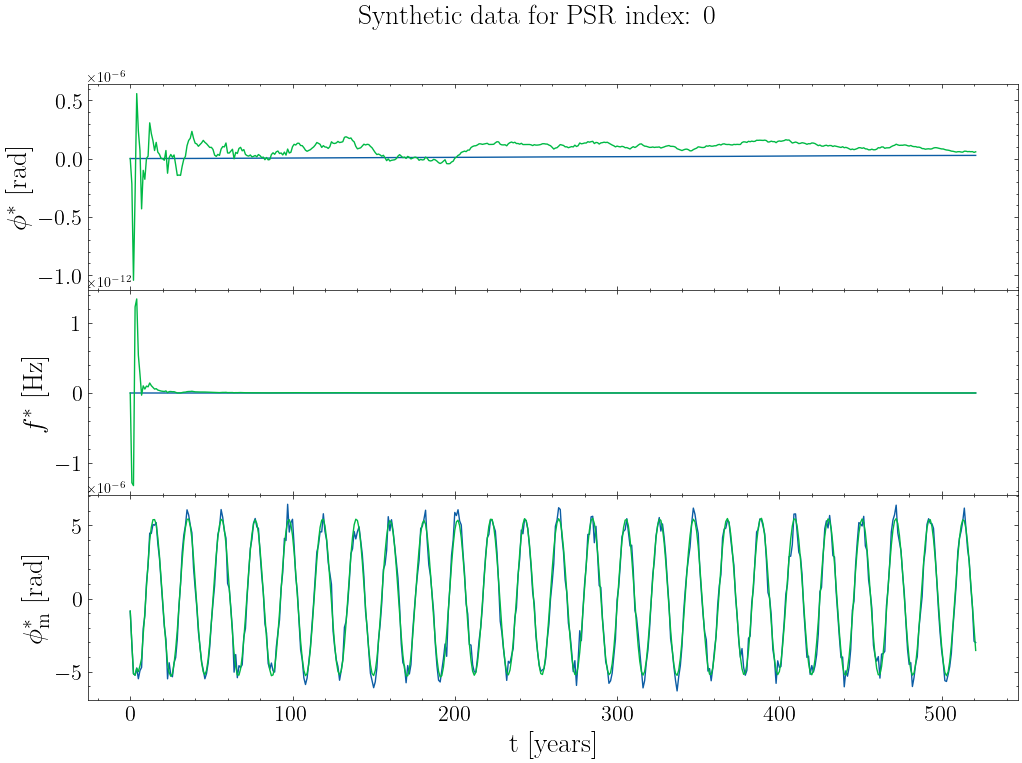

In [110]:
P   = SystemParameters(seed=1230,Npsr=0,σm=5e-7)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = PhaseModel(P)


#Initialise the Kalman filter
KF = KalmanFilter(model,data.phi_measured,PTA)

#Run the KF with the correct parameters.
#We get the correct parameters via Bilby dictionary, looking towards when we will run this with nested sampling


constrained_prior = bilby_priors_dict(PTA,P,set_state_parameters_as_known=True,set_measurement_parameters_as_known=True)
optimal_parameters = constrained_prior.sample(1)
ll,xresults,yresults = KF.likelihood(optimal_parameters)

#...and plot the results 
results_phi = xresults[:,0::2]
results_f = xresults[:,1::2] 
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0,state_phi_pred=results_phi,state_f_pred=results_f,phi_measured_pred=yresults)
print(f"The likelihood is {ll}")


Ok now the likelihood is worse (makes sense, more noise) and the state estimates are generally less good, especially at the start, but projecting the states into the measurement space gives decent results. 

If we pass the wrong parameters, the likelihood should be less and the filter should be worse:

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1230
INFO:root:You are including the PSR terms in your synthetic data generation
INFO:root:You are using the Pulsar terms measurement model
INFO:root:Setting the bilby priors dict
INFO:root:Setting uninformative priors on GW parameters. NOTE: this needs updating
INFO:root:Setting uninformative priors on PSR parameters. NOTE: just a place holder and need updating to be accurate


first state phase value =  0.0
first state frequency value =  0.0
The likelihood is nan


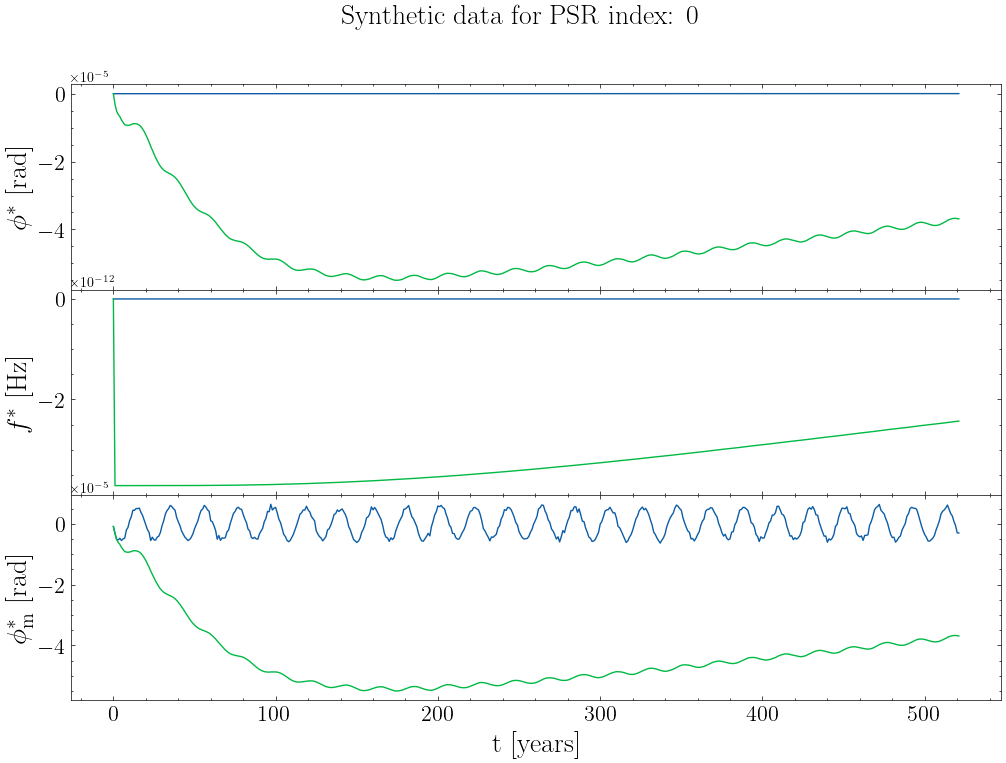

In [112]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import PhaseModel
from kalman_filter import KalmanFilter
from priors import bilby_priors_dict


P   = SystemParameters(seed=1230,Npsr=0,σm=5e-7)    # User-specifed system parameters
PTA = Pulsars(P)            # All pulsar-related quantities
data = SyntheticData(PTA,P) # Given the user parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = PhaseModel(P)


#Initialise the Kalman filter
KF = KalmanFilter(model,data.phi_measured,PTA)

#Run the KF with the correct parameters.
#We get the correct parameters via Bilby dictionary, looking towards when we will run this with nested sampling


loose_prior = bilby_priors_dict(PTA,P,set_state_parameters_as_known=False,set_measurement_parameters_as_known=False)
sub_optimal_parameters = loose_prior.sample(1)
sub_optimal_parameters["omega_gw"] = np.array([1e-1])
ll,xresults,yresults = KF.likelihood(sub_optimal_parameters)

#...and plot the results 
results_phi = xresults[:,0::2]
results_f = xresults[:,1::2] 
plot_synthetic_data(data.t,data.state_phi,data.state_f,data.phi_measured,psr_index=0,state_phi_pred=results_phi,state_f_pred=results_f,phi_measured_pred=yresults)
print(f"The likelihood is {ll}")

In [1]:
from scipy import sparse
from numba import njit

@njit
def print_csr(A, iA, jA):
    for row in range(len(iA)-1):
        for i in range(iA[row], iA[row+1]):
            print(row, jA[i], A[i])

A = sparse.csr_matrix([[1, 2, 0], [0, 0, 3], [4, 0, 5]])
print_csr(A.data, A.indptr, A.indices)

0 0 1
0 1 2
1 2 3
2 0 4
2 2 5


In [2]:
A.indptr

array([0, 2, 3, 5], dtype=int32)